In [1]:
# Gross code to allow for importing from parent directory
import os, sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))

In [2]:
import torch
import pandas as pd

import einops
from transformer_lens import HookedTransformer, ActivationCache
from load_data import get_prompts_t

import seaborn as sns

torch.set_grad_enabled(False)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

In [3]:
model = HookedTransformer.from_pretrained('gelu-4l')
model.cfg.use_attn_result = True
model.to(device);

Loaded pretrained model gelu-4l into HookedTransformer
Moving model to device:  cpu


In [4]:
prompts = get_prompts_t()

Loading 80 prompts from c4-tokenized-2b...


  0%|          | 0/80 [00:00<?, ?it/s]

Loading 20 prompts from code-tokenized...


  0%|          | 0/20 [00:00<?, ?it/s]

In [5]:
prompts.shape

torch.Size([100, 1024])

In [6]:
%%time
logits, cache = model.run_with_cache(
    prompts,
    names_filter=lambda name: "resid" in name,
)

CPU times: user 1min 49s, sys: 2min 13s, total: 4min 3s
Wall time: 13.5 s


In [7]:
cache_keys = ["blocks.0.hook_resid_pre"] + [k for k in cache.keys() if "_pre" not in k]
cache_keys

['blocks.0.hook_resid_pre',
 'blocks.0.hook_resid_mid',
 'blocks.0.hook_resid_post',
 'blocks.1.hook_resid_mid',
 'blocks.1.hook_resid_post',
 'blocks.2.hook_resid_mid',
 'blocks.2.hook_resid_post',
 'blocks.3.hook_resid_mid',
 'blocks.3.hook_resid_post']

In [8]:
df = pd.DataFrame()

for key in cache_keys:
    tmp_df = pd.DataFrame({
        "resid_norms": cache[key].norm(2, dim=-1).flatten().cpu().numpy(),
        "name": key,
    })
    df = pd.concat([df, tmp_df])

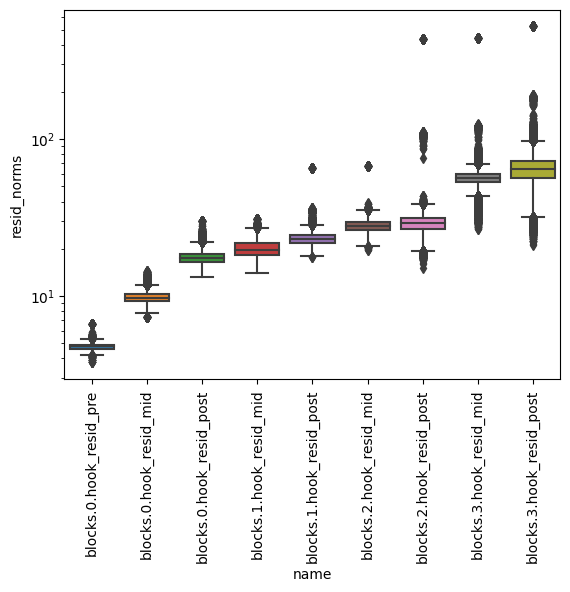

In [9]:
ax = sns.boxplot(data=df, x="name", y="resid_norms", order=cache_keys)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yscale("log");

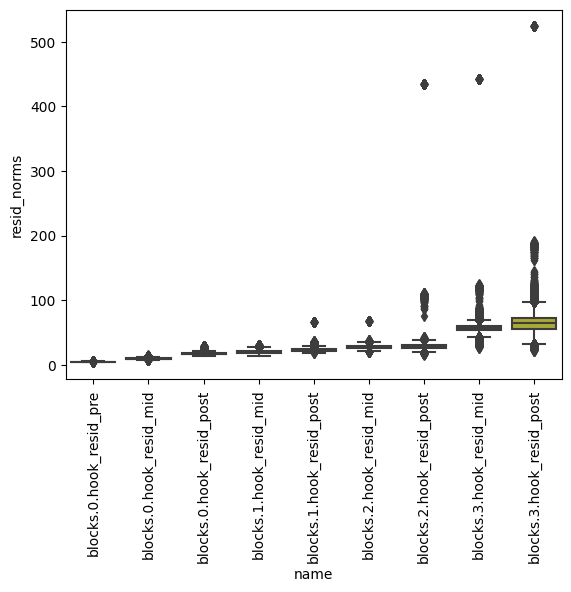

In [10]:
ax = sns.boxplot(data=df, x="name", y="resid_norms", order=cache_keys)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
# ax.set_yscale("log");